## Importing statistical modeling and word count vectorizing libraries

In [67]:
import pandas as pd 
import numpy as np 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.model_selection import cross_val_predict, cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns 

In [68]:

kjv = pd.read_csv('./my_datasets/kjv_genre_text.csv')
asv = pd.read_csv('./my_datasets/asv_genre_text.csv')
bbe = pd.read_csv('./my_datasets/bbe_genre_text.csv')
wbt = pd.read_csv('./my_datasets/wbt_genre_text.csv')
web = pd.read_csv('./my_datasets/web_genre_text.csv')
ylt = pd.read_csv('./my_datasets/ylt_genre_text.csv')

In [69]:

kjv.head()

,genre,text
0,1,In the beginning God created the heaven and th...
1,1,"And the earth was without form, and void; and ..."
2,1,"And God said, Let there be light: and there wa..."
3,1,"And God saw the light, that it was good: and G..."
4,1,"And God called the light Day, and the darkness..."


# Baseline class percentage 

In [70]:
kjv['genre'].value_counts(normalize=True, ascending=True)

8    0.012989
6    0.032376
1    0.049288
7    0.088995
5    0.152333
3    0.181462
4    0.217921
2    0.264637
Name: genre, dtype: float64

## Visualize the class distribution above 

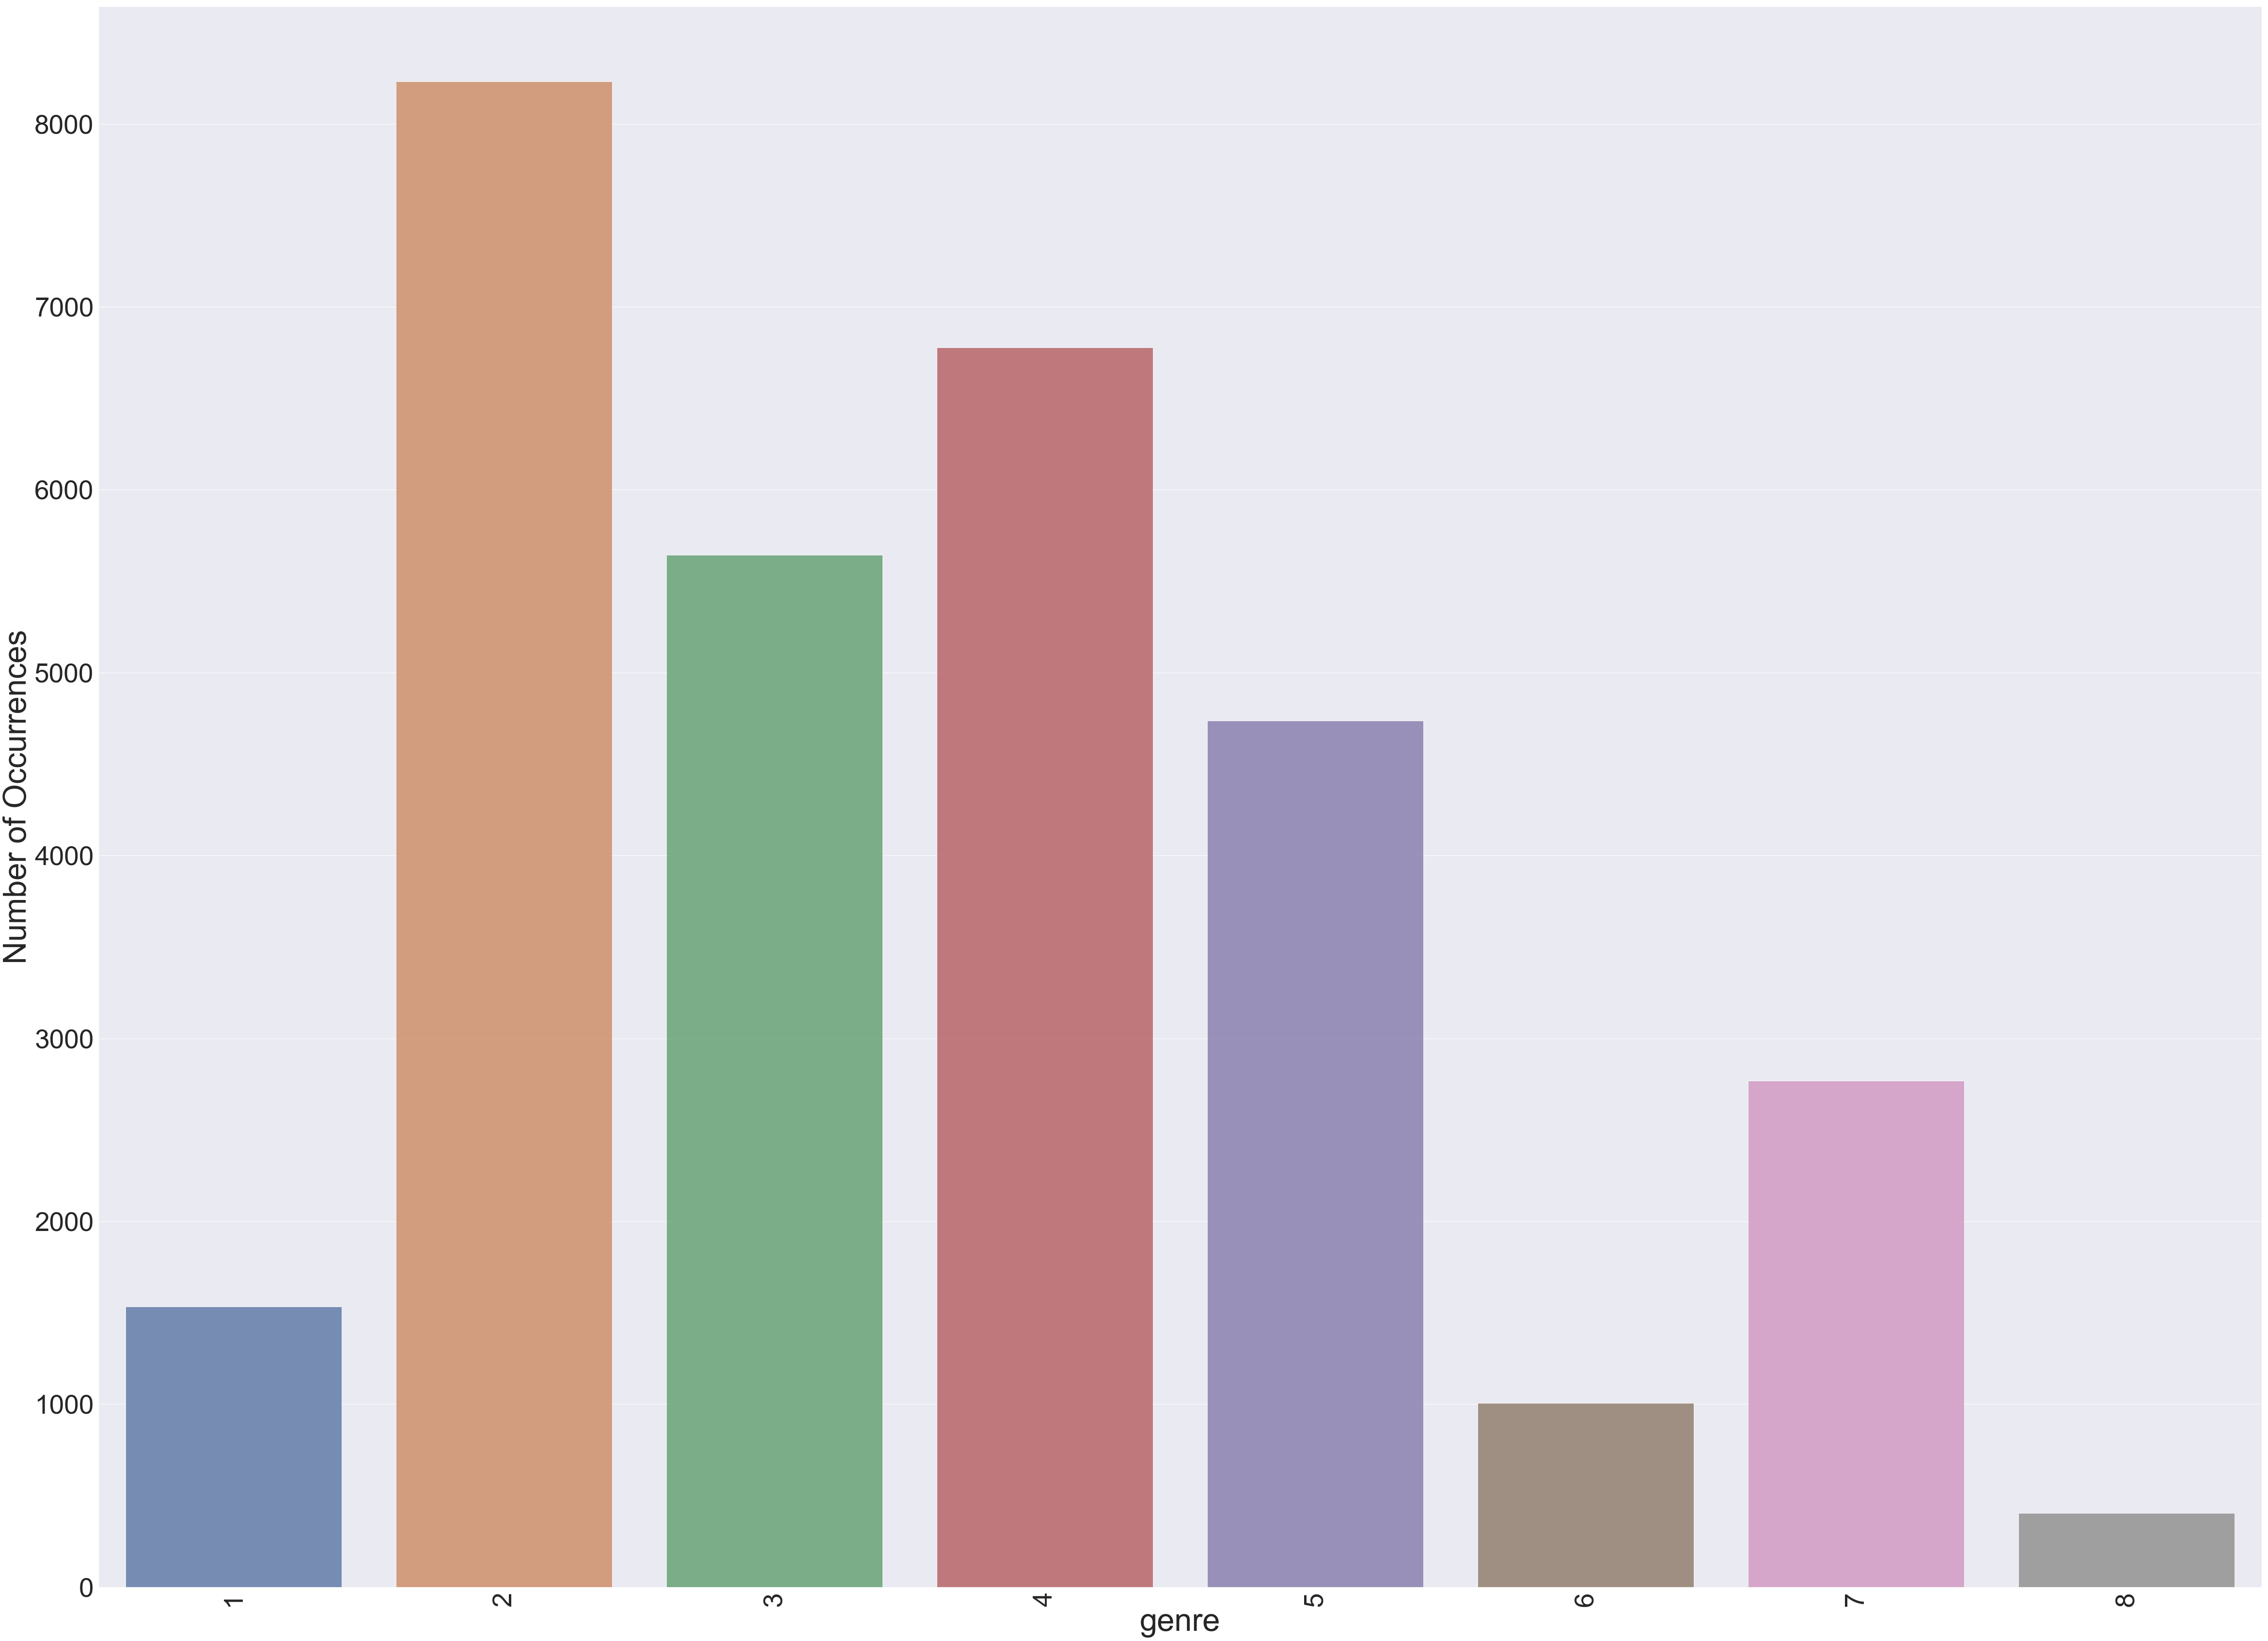

In [134]:
sns.set(font_scale=5)

cnt_pro =kjv['genre'].value_counts()
plt.figure(figsize=(80,60))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=65)
plt.xlabel('genre', fontsize=65)
plt.xticks(rotation=90)
plt.show();

# Train/test split 


In [71]:

X = kjv['text']
y = kjv['genre']

print(X.shape)
print(y.shape)

(31103,)
(31103,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   random_state=51419,
                                                   stratify=y)

In [73]:

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((23327,), (7776,), (23327,), (7776,))

## Simple TFIDF and Logistic Regression baseline score before parameter tuening 

In [74]:
tf = TfidfVectorizer(stop_words = 'english')


In [75]:
pipe = Pipeline([
        ('tf', TfidfVectorizer()),
        ('lr', LogisticRegression())
    ])

In [76]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.6965313787235135

In [77]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

In [78]:
pipe.score(X_train, y_train)

0.7824409482573842

In [79]:
pipe.score(X_test, y_test) 

0.7136059670781894

# Tfidf parameter tuening 

In [83]:

def scale_model_evaluate(X, y, model_name='lr', 
                         tokenizer_name='tfidf', 
                         tokenizer = TfidfVectorizer(),
                       model_type=LogisticRegression(), 
                       parameters={'tfidf__max_df': [.1, .2],
                                   'tfidf__min_df': [.09, 1],
                                   'tfidf__ngram_range': (1.3, 1),
                                   'lr__penalty': ['l1', 'l2'],
                                   'lr__C': np.logspace(0, 5, 10),
                                   'lr__penalty': ['l1', 'l2'],
                                   'lr__C': np.logspace(0, 5, 10),
                                   'lr__n_jobs': [1], 
                                  }
                        ):
 
    
    pipe=Pipeline(memory=None,
         steps=[(tokenizer_name,tokenizer),
                (model_name,model_type)])
                         
 
    grid = GridSearchCV(pipe, param_grid=parameters, cv=5)
    grid = grid.fit(X, y) 
    
    
    
    
    print(f"For model: {model_type}")
    print(f"The best parameters are: {grid.best_params_}")
    print(f"The best score is: {grid.best_score_:.2f}")
    return grid


In [84]:
scale_model_evaluate(X_train, y_train, 
                     model_name='lr', 
                     tokenizer_name='tfidf',
                     tokenizer = TfidfVectorizer(),
                     parameters={'tfidf__max_df': [.1, .2],
                                 'tfidf__min_df': [.09, 1],
                                 'tfidf__ngram_range':[(1, 1), (1, 2)],
                                 'lr__penalty': ['l1', 'l2'],
                                 'lr__n_jobs': [1]
                                } )

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


For model: LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
The best parameters are: {'lr__n_jobs': 1, 'lr__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
The best score is: 0.70


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,...penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'tfidf__max_df': [0.1, 0.2], 'tfidf__min_df': [0.09, 1], 'tfidf__ngram_range': [(1, 1), (1, 2)], 'lr__penalty': ['l1', 'l2'], 'lr__n_jobs': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

# Multinomial NB and Tfidf 

In [93]:
pipe = Pipeline([
        ('tf', TfidfVectorizer()),
        ('nb', MultinomialNB())
    ])

In [94]:
cross_val_score(pipe, X_train, y_train, cv=5).mean() 

0.6111375963131056

In [95]:
pipe.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('tf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
  ...True,
        vocabulary=None)), ('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [96]:
pipe.score(X_train, y_train)

0.6897157799974278

In [97]:
pipe.score(X_test, y_test) 

0.6291152263374485

## Doc-2-vec 

Source : https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [99]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
import gensim
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords 

In [100]:
kjv.head()

,genre,text
0,1,In the beginning God created the heaven and th...
1,1,"And the earth was without form, and void; and ..."
2,1,"And God said, Let there be light: and there wa..."
3,1,"And God saw the light, that it was good: and G..."
4,1,"And God called the light Day, and the darkness..."


## Train/test split 

In [139]:
train, test = train_test_split(kjv, test_size=0.3, random_state=1519)

In [102]:
text = kjv['text']

In [103]:
genre = kjv['genre']

##  Tokenize text 

In [104]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.genre]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.genre]), axis=1)

In [140]:
train_tagged.values[100]

TaggedDocument(words=['then', 'said', 'absalom', 'if', 'not', 'pray', 'thee', 'let', 'my', 'brother', 'amnon', 'go', 'with', 'us', 'and', 'the', 'king', 'said', 'unto', 'him', 'why', 'should', 'he', 'go', 'with', 'thee'], tags=[2])

## Assigning multi processing cores 

In [107]:
import multiprocessing

cores = multiprocessing.cpu_count()

In [108]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 21772/21772 [00:00<00:00, 2225920.46it/s]


In [109]:

%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha


100%|██████████| 21772/21772 [00:00<00:00, 3237551.82it/s]


CPU times: user 41.5 s, sys: 8.08 s, total: 49.5 s
Wall time: 26.2 s


# Buliding the final vector feature for the classifier

In [110]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [111]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)

In [112]:
lr = LogisticRegression(n_jobs=1, C=1e5)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [113]:
from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


Testing accuracy 0.3026470903440146
Testing F1 score: 0.2586065373557187


# Distributed Memory with Averaging

In [114]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 21772/21772 [00:00<00:00, 2452883.15it/s]


In [115]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 21772/21772 [00:00<00:00, 3104061.55it/s]


CPU times: user 1min 4s, sys: 18.8 s, total: 1min 23s
Wall time: 43.2 s


# Train Logistic Regression 

In [116]:
y_train, X_train = vec_for_learning(model_dmm, train_tagged)
y_test, X_test = vec_for_learning(model_dmm, test_tagged)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.45279176937091414
Testing F1 score: 0.4649251195240837


In [121]:
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dmm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [122]:
# !pip install testfixtures

In [123]:
from gensim.test.test_doc2vec import ConcatenatedDoc2Vec
new_model = ConcatenatedDoc2Vec([model_dbow, model_dmm])

## Building feature vectors 

In [124]:
def get_vectors(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [125]:
y_train, X_train = get_vectors(new_model, train_tagged)
y_test, X_test = get_vectors(new_model, test_tagged)

In [126]:
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/mekdes/anaconda3/envs/dsi/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.44271782231272105
Testing F1 score: 0.4600049586428975
